# sDMD example
This Python notebook walks you through the process of utilizing the sDMD algorithm for tracking a real-time multidimensional signal, as well as demonstrating how to perform on-the-fly predictions. Let's first import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sDMD.sDMD import sDMD


First we generate some fake data which follows a simple discrete linear system with noise:

$$ y_{k+1} = \textbf{A}y_{k} + v_k$$

We will store the snapshots of $y_k$ in a 2D array, $Y$, where each column is a different observation. The oldest observations are on the left. This can be replaced by real time series data (e.g. stock market prices), as long as each observation is stored in columns, and each row is a different channel, and all data is numeric.

$$
\textbf{Y} = [y_0, y_1, ..., y_N]
$$

Lets define $\textbf{A}$ as a random (but stable) discrete system with 3 dimensions. $\textbf{A}$ is unknown to the sDMD algorithm, but that doesn't stop it from recreating it from the data. Lets also define the time series length as $N=500$, and the initial observation arbitrarily as $y_0 = [1.0, 2.0, 3.0]$

In [2]:
A = np.array(
    [
        [0.40666516, 0.10076346, -0.12854121],
        [1.42620578, 0.52241437, -0.69365636],
        [2.28179253, 0.8219495, -1.25244542],
    ]
)

N = 500

Y = np.zeros([3, N])
Y[:, 0] = [1, 2, 3]


Moving forward, we'll loop through each time step and fill the dataset based on the discrete linear system equation described above. As depicted in the figure, the three signals take the form of a generic time series data, serving as an ideal representation for demonstrating the sDMD algorithm.

Text(0.5, 0, 'time step')

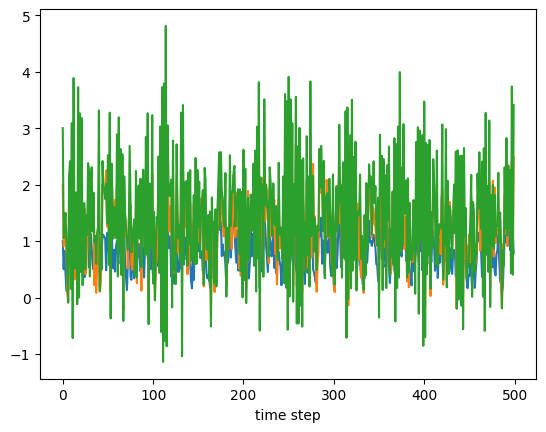

In [3]:

for i in range(N - 1):
    Y[:, i + 1] = A @ Y[:, i] + np.random.rand(3)

plt.plot(Y.T)
plt.xlabel("time step")


Having obtained our synthetic time series dataset, it's time to apply the sDMD algorithm. We should approach the dataset as if we're progressing chronologically, unveiling new timestep data with each iteration.

To begin, we give the sDMD a chunk of data to get the algorithm started. Lets give give the first 100 snapshots (`y_start`). Additionally, lets set some parameters for sDMD. Lets set $r_{min}=2$, $r_{max}=3$, and lets try to predict 5 time steps into the future, so $f=5$. There is the option to stack the observations (Hankel matrix), but let's leave that out for simplicity by setting $s=1$. (check the paper for more details on these parameters).

In [4]:
y_start, y_rest = Y[:, :100], Y[:, 100:]

sdmd = sDMD(y_start, rmin=2, rmax=3, f=5, s=1)


Now lets simulate running the sDMD algorithm in real-time by stepping through the remaining data stored in `y_rest`. As new observations are made available, they are sent to the sdmd algorithm one-by-one using the update function (`sdmd.update(y)`).

We can perform forecasts $f$ time steps into the future ($f=$ as defined in the previous block) by using the prediction equation (see Eq. 27 in the paper):

$$
\tilde{y}_{k+f} = \textbf{U}_y\textbf{A}\textbf{U}_x^Ty_k
$$

At each time step, we therefore perform an update in the sDMD algorithm as well as a prediction. This prediction is stored in `Y_predict`.

In [5]:
Y_predict = []
for y in y_rest.T:
    out = sdmd.update(y)

    # Furute prediction based on current observation (Eq. 27)
    prediction = sdmd.Uy @ sdmd.A @ sdmd.Ux.T @ y
    Y_predict.append(prediction)

Y_predict = np.array(Y_predict).T



Finally, lets take a look at our prediction compared to the actual values by plotting them against each other. Note we remove the first $f$ observations from `y_rest` to make sure the predictions (which are $f$ time steps ahead) line up with the measurements.

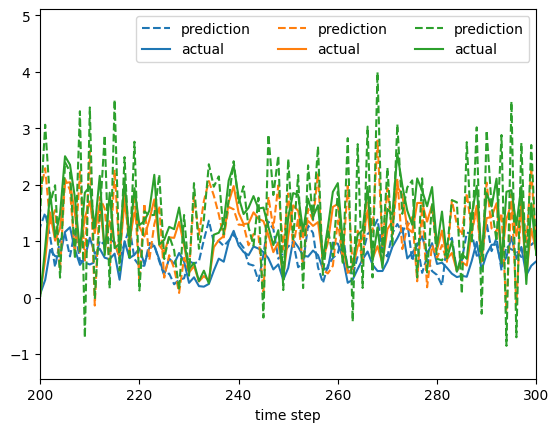

In [6]:

for y_actual, y_predict, color in zip(
    y_rest[:, sdmd.f:], Y_predict, ["tab:blue", "tab:orange", "tab:green"]
):
    plt.plot(y_actual, "--", color=color, label="prediction")
    plt.plot(y_predict, color=color, label="actual")
plt.xlim(200, 300)
plt.xlabel("time step")
plt.legend(ncol=3)
